# Mission  特征工程
---


## 任务
分别用IV值和随机森林挑选特征，再构建模型，进行模型评估

In [8]:
# 导入需要的包
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, classification_report
from model_config import clfs

# 设置 pandas 显示列数
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)

## 1. 导入数据，2. 特征处理

In [43]:
# 假设前面我们已经将处理好的数据存到一个 cl_data.pkl 的文件
import pickle as pkl
with open('./data/cl_data.pkl', 'rb') as f:
    cl_data = pkl.load(f)

X_cl = cl_data['X_cl']
y = cl_data['y']

# 数据构成
print('X.shape:', X_cl.shape)
print('y 的分布\n', y.value_counts())

X.shape: (4754, 89)
y 的分布
 0    3561
1    1193
Name: status, dtype: int64


### 2.1 使用 IV 值进行特征筛选


In [51]:
# 计算 IV 函数
def cal_iv(x, y, n_bins=6, null_value=np.nan,):
    # 剔除空值
    x = x[x != null_value]
    
    # 若 x 只有一个值，返回 0
    if len(x.unique()) == 1 or len(x) != len(y):
        return 0
    
    if x.dtype == np.number:
        # 数值型变量
        if x.nunique() > n_bins:
            # 若 nunique 大于箱数，进行分箱
            x = pd.qcut(x, q=n_bins, duplicates='drop')
                
    # 计算IV
    groups = x.groupby([x, list(y)]).size().unstack().fillna(0)
    t0, t1 = y.value_counts().index
#     if null_value is not np.nan:
#         groups = groups.loc[groups.index != null_value, :]
    groups = groups / groups.sum()
    not_zero_index = (groups[t0] > 0) & (groups[t1] > 0)
    groups['iv_i'] = (groups[t0] - groups[t1]) * np.log(groups[t0] / groups[t1])
#     groups.loc[~not_zero_index, 'iv_i'] = 0
#     groups['woe'] = np.log(groups[t0] / groups[t1])
#     groups.loc[~not_zero_index, 'woe'] = 0
    iv = sum(groups['iv_i'])
#     woe_map = groups['woe']

    return iv

In [52]:
# 统计每个特征对应的 iv 值
fea_iv = X_cl.apply(lambda x: cal_iv(x, y), axis=0).sort_values(ascending=False)
print(fea_iv)

trans_fail_top_count_enum_last_1_month        0.594725
history_fail_fee                              0.523103
loans_score                                   0.433950
apply_score                                   0.383065
loans_overdue_count                           0.337394
trans_fail_top_count_enum_last_12_month       0.242439
latest_one_month_fail                         0.233159
trans_fail_top_count_enum_last_6_month        0.226004
latest_one_month_suc                          0.141729
rank_trad_1_month                             0.111234
max_cumulative_consume_later_1_month          0.108685
trans_day_last_12_month                       0.093933
top_trans_count_last_1_month                  0.065016
consfin_avg_limit                             0.057349
pawns_auctions_trusts_consume_last_1_month    0.050321
trans_amount_3_month                          0.041933
consfin_credit_limit                          0.041048
consume_mini_time_last_1_month                0.040272
trans_top_

In [26]:
# 筛选 IV > 0.1 的特征
imp_fea_iv = fea_iv[fea_iv > 0.05].index
imp_fea_iv

Index(['trans_fail_top_count_enum_last_1_month', 'history_fail_fee', 'loans_score', 'apply_score', 'loans_overdue_count', 'trans_fail_top_count_enum_last_12_month', 'latest_one_month_fail', 'trans_fail_top_count_enum_last_6_month', 'latest_one_month_suc', 'rank_trad_1_month', 'max_cumulative_consume_later_1_month', 'trans_day_last_12_month', 'top_trans_count_last_1_month', 'consfin_avg_limit', 'pawns_auctions_trusts_consume_last_1_month'], dtype='object')

### 2.2 使用 随机森林 进行特征筛选

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_cl, y)

rf_impc = pd.Series(rf.feature_importances_, index=X_cl.columns).sort_values(ascending=False)
print(rf_impc)

trans_fail_top_count_enum_last_1_month        0.048011
history_fail_fee                              0.038843
apply_score                                   0.029526
loans_score                                   0.026811
latest_one_month_fail                         0.024758
trans_fail_top_count_enum_last_6_month        0.023462
loans_overdue_count                           0.018845
max_cumulative_consume_later_1_month          0.018648
trans_amount_3_month                          0.018372
avg_price_last_12_month                       0.017161
historical_trans_amount                       0.016864
loans_latest_day                              0.016319
repayment_capability                          0.016282
first_transaction_day                         0.016248
trans_days_interval_filter                    0.016159
consfin_avg_limit                             0.014916
loans_count                                   0.014770
first_transaction_time                        0.014636
trans_fail

In [53]:
# 筛选 重要性前十五 个特征
imp_fea_rf = rf_impc.index[:15]
imp_fea_rf

Index(['trans_fail_top_count_enum_last_1_month', 'history_fail_fee', 'apply_score', 'loans_score', 'latest_one_month_fail', 'trans_fail_top_count_enum_last_6_month', 'loans_overdue_count', 'max_cumulative_consume_later_1_month', 'trans_amount_3_month', 'avg_price_last_12_month', 'historical_trans_amount', 'loans_latest_day', 'repayment_capability', 'first_transaction_day', 'trans_days_interval_filter'], dtype='object')

In [55]:
# fea_iv.to_csv('iv_by_long.csv')
# rf_impc.to_csv('rf_by_long.csv')

In [44]:
# 合并特征并筛选出有用特征
imp_fea = list(set(imp_fea_iv) | set(imp_fea_rf))
X_imp = X_cl[imp_fea]
X_imp.shape

(4754, 22)

## 3. 数据划分
为了避免训练集太少，使用 二八 分

In [45]:
from sklearn.model_selection import train_test_split
random_state = 1115
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, random_state=random_state)
print(X_train.shape)
print(X_test.shape)

(3803, 22)
(951, 22)


In [46]:
# 数据归一化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

## 4. 建模，5. 调参
假设已经将经过调完参数的模型存放在 model_config 的 clfs 中

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

# 读取模型
lr = clfs.get('lr')
linear_svc = clfs.get('linear_svc')
poly_svc = clfs.get('poly_svc')
dt = clfs.get('dt')
xgb_model = clfs.get('xgb')
lgb_model = clfs.get('lgb')

## 6. 模型融合 stacking
关于stacking的原理：[stacking 模型融合](https://blog.csdn.net/yc1203968305/article/details/73526615)

为了贯彻调包侠的理念，这里直接调用 mlxtend 库里面的 StackingCVClassifier 进行建模，这个库可以很好地完成对 sklearn 的 stacking。参考：[StackingClassifier](https://blog.csdn.net/github_35965351/article/details/60763606)

In [48]:
from mlxtend.classifier import StackingCVClassifier, StackingClassifier

# 构建 Stacking 模型，因为 dt 评分太低了，所以抛弃掉，使用 lr 作为最后的融合模型
s_clf = StackingClassifier(classifiers=[linear_svc, xgb_model, lgb_model], 
                             meta_classifier=lr, use_probas=True, verbose=3)

s_clf.fit(X_train_std, y_train)

Fitting 3 classifiers...
Fitting classifier1: svc (1/3)
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=1)
[LibSVM]Fitting classifier2: xgbclassifier (2/3)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=42,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=112,
       silent=True, subsample=0.8)
Fitting classifier3: lgbmclassifier (3/3)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        gamma=0, importance_type='split', learning_rate=0.1, max_depth=5,
        min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
        n_estimators=42

StackingClassifier(average_probas=False,
          classifiers=[SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), XGBClassifier(base_score=0.5, booster='gbtree', colsample_byl...weight=1, seed=112, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=0)],
          meta_classifier=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=True, verbose=3)

准确性：
Train：0.9019
Test：0.7886
精确率：
Train：0.8748
Test：0.6264
召回率：
Train：0.7078
Test：0.4449
f1_score：
Train：0.7825
Test：0.5203
roc_auc：
Train：0.9476
Test：0.7651
KS：
Train：0.7501
Test：0.3994


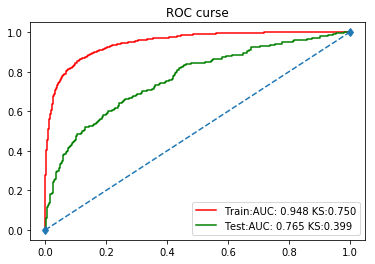

In [50]:
# 评估 Stacking 模型
model_metrics(s_clf, X_train_std, X_test_std, y_train, y_test)

## 5. 评估

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from matplotlib import pyplot as plt
# 定义评估函数
def model_metrics(clf, X_train, X_test, y_train, y_test, i=0):
    # 预测
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred_proba = clf.predict_proba(X_train)[:, 1]
    y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

    # 评估
    # 准确性
    print('准确性：')
    print('Train：{:.4f}'.format(accuracy_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(accuracy_score(y_test, y_test_pred)))
    
    # 精准率
    print('精确率：')
    print('Train：{:.4f}'.format(precision_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(precision_score(y_test, y_test_pred)))

    # 召回率
    print('召回率：')
    print('Train：{:.4f}'.format(recall_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(recall_score(y_test, y_test_pred)))
    
    # f1_score
    print('f1_score：')
    print('Train：{:.4f}'.format(f1_score(y_train, y_train_pred)))
    print('Test：{:.4f}'.format(f1_score(y_test, y_test_pred)))
    
    # roc_auc
    print('roc_auc：')
    print('Train：{:.4f}'.format(roc_auc_score(y_train, y_train_pred_proba)))
    print('Test：{:.4f}'.format(roc_auc_score(y_test, y_test_pred_proba)))    
    
    # 描绘 ROC 曲线
    fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_te, tpr_te, _ = roc_curve(y_test, y_test_pred_proba)

    # KS
    print('KS：')
    print('Train：{:.4f}'.format(max(abs((fpr_tr - tpr_tr)))))
    print('Test：{:.4f}'.format(max(abs((fpr_te - tpr_te)))))

    # 绘图
    plt.figure(i)
    plt.plot(fpr_tr, tpr_tr, 'r-',
             label="Train:AUC: {:.3f} KS:{:.3f}".format(roc_auc_score(y_train, y_train_pred_proba), 
                                                        max(abs((fpr_tr - tpr_tr)))))
    plt.plot(fpr_te, tpr_te, 'g-',
             label="Test:AUC: {:.3f} KS:{:.3f}".format(roc_auc_score(y_test, y_test_pred_proba),
                                                     max(abs((fpr_te - tpr_te)))))
    plt.plot([0, 1], [0, 1], 'd--')
    plt.legend(loc='best')
    plt.title("ROC curse")
    plt.show()